In [1]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import Tool
from langchain_experimental.utilities import PythonREPL
from langchain_experimental.tools import PythonREPLTool

In [2]:
tavily_tool = TavilySearchResults(max_results=5)

python_repl_tool = PythonREPLTool()

In [3]:
from langchain_core.messages import HumanMessage
from langchain_groq import ChatGroq

llm=ChatGroq(model="llama3-70b-8192")

In [4]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}

In [5]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel
from typing import Literal

In [6]:
members = ["Researcher", "Coder"]

In [7]:
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

In [8]:
options = ["FINISH"] + members

In [9]:
options

['FINISH', 'Researcher', 'Coder']

In [10]:
options=tuple(options)

In [11]:
class routeResponse(BaseModel):
    next: Literal['FINISH', 'Researcher', 'Coder']

In [12]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

In [13]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001CE0DB4AF90>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001CE0DB84140>, model_name='llama3-70b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [14]:
def supervisor_agent(state):
    supervisor_chain = (
        prompt | llm.with_structured_output(routeResponse)
    )
    return supervisor_chain.invoke(state)

In [15]:
import functools
import operator
from typing import Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent

In [16]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str

In [17]:
research_agent = create_react_agent(llm, tools=[tavily_tool])

In [18]:
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

In [19]:
code_agent = create_react_agent(llm, tools=[python_repl_tool])
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

In [20]:
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_agent)
for member in members:
    workflow.add_edge(member, "supervisor")
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
workflow.add_edge(START, "supervisor")
graph = workflow.compile()

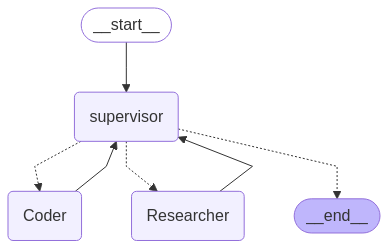

In [21]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [22]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
):
    if "__end__" in s:
        print("End of stream. Stopping...")
        break  # <<<<<< This stops the loop
    print(s)
    print("----")

{'supervisor': {'next': 'Coder'}}
----


Python REPL can execute arbitrary code. Use with caution.


{'Coder': {'messages': [HumanMessage(content='Hello, World!', additional_kwargs={}, response_metadata={}, name='Coder')]}}
----
{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='The phrase "Hello World" is a traditional introductory program used in programming, often written by students of a new programming language. It is a simple program that displays "Hello, World!" to the user, illustrating a language\'s basic syntax. It has become a symbol of community and shared experience among programmers, transcending language barriers and uniting developers around the world.', additional_kwargs={}, response_metadata={}, name='Researcher')]}}
----
{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='It seems like the tool call yielded several search results related to "Hello World". Would you like me to help you with something specific or would you like to ask a question about these results?', additional_kwa

KeyboardInterrupt: 

In [23]:
graph.invoke(
    {"messages": [HumanMessage(content="Write a brief research report on pikas.")]}
)

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [ ]:
for s in graph.stream(
    {"messages": [HumanMessage(content="Write a brief research report on pikas.")]},
    {"recursion_limit": 5},
):
    if "__end__" not in s:
        print(s)
        print("----")